<a href="https://colab.research.google.com/github/fbison/InferenciaDeHabilidadeTRI/blob/main/InferenciaTRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

def read_file(filename):
  with open(filename, 'r') as f:
    lines = f.readlines()
  return lines


# Upload the file to Colab
from google.colab import files
uploaded = files.upload()

# Read the lines from the uploaded file
lines = read_file('parametros_enem.txt')

Saving parametros_enem.txt to parametros_enem (6).txt


In [ ]:
uploaded = files.upload()
acertos = read_file('file.txt')

Saving file.txt to file (1).txt


In [ ]:
def generate_array_ofBytes(string):
  # Divide a string em uma lista de strings separadas por espaços.
  list_of_strings = string.split()
  array = []

  for element in list_of_strings:
    if element == 'NaN':
      array.append(float('NaN'))
    else:
      array.append(int(element))
  # Retorna o array de inteiros.
  return array

def process_candidates_answers(examples):
    candidatesAnswers = [generate_array_ofBytes(example.strip()) for example in examples]
    return candidatesAnswers
acertos = process_candidates_answers(acertos)

In [ ]:
dict = {}

In [ ]:
import numpy as np;
def parse_values(input_string):
    # Dividir a string em uma lista de valores
    values = input_string.split()

    if len(values) != 3:
        raise ValueError("A string deve conter exatamente três valores numéricos separados por espaços.")

    # Atribuir os valores às variáveis A, B, e C
    a = float(values[0])
    b = float(values[1])
    c= float(values[2])

    return a, b, c
import copy
def create_dict(lines, candidatesAnswers):
    dict = {}

    for candidate_id, candidate_answers in enumerate(candidatesAnswers):
        question = 0
        newkey = 1;
        for line in lines: #adiciona as questões
            if line.startswith(tuple(notebooks)):
                key = line[:2]
                if key not in dict:
                    dict[key] = {}
                if candidate_id not in dict[key]:
                    newkey = 1;
                    dict[key][candidate_id] = {'A': [], 'B': [], 'C': [], 'X': []}
                if candidate_id > 0 and newkey == 1:
                    dict[key][candidate_id]['A'] = copy.deepcopy(dict[key][0]['A'])
                    dict[key][candidate_id]['B'] = copy.deepcopy(dict[key][0]['B'])
                    dict[key][candidate_id]['C'] = copy.deepcopy(dict[key][0]['C'])
                    newkey=0;
                elif candidate_id == 0:
                    A, B, C = parse_values(line[8:])
                    dict[key][candidate_id]['A'].append(A)
                    dict[key][candidate_id]['B'].append(B)
                    dict[key][candidate_id]['C'].append(C)
                dict[key][candidate_id]['X'].append(candidate_answers[question])
                question += 1

    return dict

notebooks= ('LC', 'CN', 'CH', 'MT', 'ES', 'IN')
dict = create_dict(lines, acertos)


In [ ]:
#acertos[2024]
dict['ES'][0]['X']

[nan, nan, nan, nan, nan]

In [ ]:

def squeezeDict(dict):
  for key in dict:
    for candidate_id in dict[key].keys():
      dict[key][candidate_id]['A'] = np.squeeze(dict[key][candidate_id]['A'])
      dict[key][candidate_id]['B'] = np.squeeze(dict[key][candidate_id]['B'])
      dict[key][candidate_id]['C'] = np.squeeze(dict[key][candidate_id]['C'])
      dict[key][candidate_id]['X'] = np.squeeze(dict[key][candidate_id]['X'])

def retiraNaN(dict, keys_to_clean):
    for key in keys_to_clean:
      for candidate_id in dict[key].keys():
        A = np.array(dict[key][candidate_id]['A'], dtype=float)
        B = np.array(dict[key][candidate_id]['B'], dtype=float)
        C = np.array(dict[key][candidate_id]['C'], dtype=float)
        X = np.array(dict[key][candidate_id]['X'], dtype=float)

        # Filtrar índices válidos (não NaN)
        valid_indices = ~np.isnan(X)
        # Atualizar os arrays no dicionário com os valores filtrados
        dict[key][candidate_id]['A'] = A[valid_indices]
        dict[key][candidate_id]['B'] = B[valid_indices]
        dict[key][candidate_id]['C'] = C[valid_indices]
        dict[key][candidate_id]['X'] = X[valid_indices]

def concat_remove(dict, notebooks, keys_to_concat, target_key):
    # Concatenar arrays de keys_to_concat ao target_key
    for key in keys_to_concat:
      for candidate_id in dict[key].keys():
        for subkey in ['A', 'B', 'C', 'X']:
            dict[target_key][candidate_id][subkey] = np.concatenate((dict[target_key][candidate_id][subkey], dict[key][candidate_id][subkey]))

    # Remover keys_to_concat do dicionário
    for key in keys_to_concat:
        del dict[key]

    # Atualizar notebooks removendo keys_to_concat
    notebooks = tuple(key for key in notebooks if key not in keys_to_concat)

    return dict, notebooks
keys_to_concat = ['ES', 'IN']
target_key = 'LC'
retiraNaN(dict, keys_to_concat)


In [ ]:
dict, notebooks = concat_remove(dict, notebooks, keys_to_concat, target_key)


In [ ]:

def probabilidadeDeAcerto(A, B, C, teta):
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)
    C = np.array(C, dtype=float)

    return C + ((1 - C) / (1 + np.exp(-A * (teta - B))))

def calculaVerossemelhanca(A, B, C, teta, X):
    probabilidade = probabilidadeDeAcerto(A, B, C, teta)
    X = np.array(X, dtype=float)

    # Filtrar valores que não são NaN
    valid_indices = ~np.isnan(X)
    X_valid = X[valid_indices]
    probabilidade_valid = probabilidade[valid_indices]

    logProbabilidade = np.log(probabilidade_valid)
    log1MenosProbabilidade = np.log(1 - probabilidade_valid)

    likelihoods = X_valid * logProbabilidade + (1 - X_valid) * log1MenosProbabilidade
    likelihood = np.sum(likelihoods)

    return likelihood

def plotaGrafoDeNotebook(dict, key):
    import matplotlib.pyplot as plt
    theta_values = np.linspace(-2, 6, 150)
    # Calcular verossimilhança para cada valor de theta
    likelihoods = [calculaVerossemelhanca(dict['A'],dict['B'], dict['C'], theta, dict['X']) for theta in theta_values]

    # Plotar o gráfico
    plt.plot(theta_values, likelihoods)
    plt.xlabel('Theta (θ) de ' + key)
    plt.ylabel('Log-Verossimilhança caderno ' + key)
    plt.title('Log-Verossimilhança vs. Theta '+ key)
    plt.grid(True)
    plt.show()

<ipython-input-14-c15194e63277>:18: RuntimeWarning: divide by zero encountered in log
  log1MenosProbabilidade = np.log(1 - probabilidade_valid)


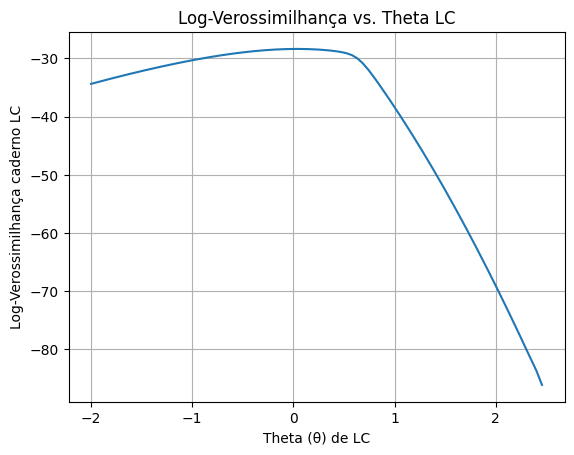

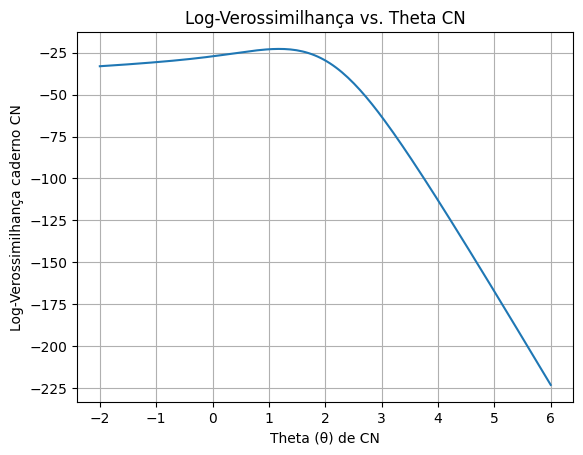

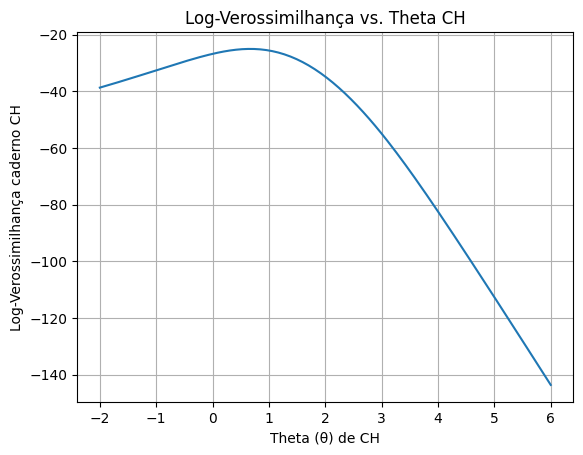

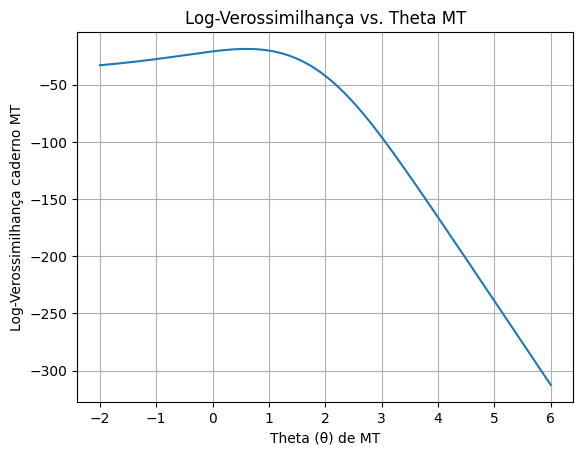

In [ ]:
for key in notebooks:
   plotaGrafoDeNotebook(dict[key][2024], key)

In [ ]:
import numpy as np
from scipy.optimize import newton
import sympy as sp

def inferencia(key, dict, candidate_id):
    theta = sp.symbols('θ')
    X = dict[key][candidate_id]['X']
    a = dict[key][candidate_id]['A']
    b = dict[key][candidate_id]['B']
    c = dict[key][candidate_id]['C']

    P_sym = [c[i] + (1 - c[i]) / (1 + sp.exp(-a[i] * (theta - b[i]))) for i in range(len(X))]
    Q_sym = [1 - P_sym[i] for i in range(len(X))]

    # Calcula a log-verossimilhança e suas derivadas
    log_likelihood = sum(X[i] * sp.log(P_sym[i]) + (1 - X[i]) * sp.log(Q_sym[i]) for i in range(len(X)))
    first_derivative = sp.diff(log_likelihood, theta)
    second_derivative = sp.diff(first_derivative, theta)

    # Converte expressões simbólicas em funções numéricas
    first_derivative_func = sp.lambdify(theta, first_derivative, 'numpy')
    second_derivative_func = sp.lambdify(theta, second_derivative, 'numpy')

    # Inicializa o valor de theta
    theta_val = 2

    # Função para ser utilizada pelo método de Newton
    def newton_func(t):
        f_val = first_derivative_func(t)
        f_prime_val = second_derivative_func(t)

        # Verifica se f_prime_val é próximo de zero para evitar divisão por zero
        if np.abs(f_prime_val) < 1e-10:
            raise ValueError("Segunda derivada próxima de zero. Método pode falhar.")
        return f_val / f_prime_val

    try:
        theta_val = newton(lambda t: first_derivative_func(t), theta_val, fprime=lambda t: second_derivative_func(t), tol=1e-6, maxiter=500)
    except RuntimeError as e:
        print(f"Falha na convergência do método de Newton: {e}")
        return float('NaN');
    except ValueError as e:
        print(f"Erro durante o cálculo de Newton: {e}")
        return float('NaN');

    return theta_val

def calculaTheta(dict):
  for candidate_id in range(383, 501):
    print('Calculando theta para o candidato ' + str(candidate_id))
    for key in dict:
      dict[key][candidate_id]['teta'] = inferencia(key, dict, candidate_id)
calculaTheta(dict)

Calculando theta para o candidato 208


<lambdifygenerated-1989>:2: RuntimeWarning: overflow encountered in exp
  return -0.267649907664248*exp(-1.088866*θ)/((0.99999999511145 - 0.99999999511145/(1 + 0.245806103756263*exp(-1.088866*θ)))*(1 + 0.245806103756263*exp(-1.088866*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.354142

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 209
Calculando theta para o candidato 210
Calculando theta para o candidato 211
Calculando theta para o candidato 212
Calculando theta para o candidato 213
Calculando theta para o candidato 214
Calculando theta para o candidato 215
Calculando theta para o candidato 216
Calculando theta para o candidato 217
Calculando theta para o candidato 218
Calculando theta para o candidato 219


<lambdifygenerated-2078>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.256714533679922*exp(-1.0765426*θ)/((1 - 1/(1 + 0.94129121168158*exp(-0.5382713*θ)))**2*(1 + 0.94129121168158*exp(-0.5382713*θ))**4) - 0.114791413520736*exp(-1.2673376*θ)/((1 - 1/(1 + 0.53467807723668*exp(-0.6336688*θ)))**2*(1 + 0.53467807723668*exp(-0.6336688*θ))**4) - 0.36736426948086*exp(-1.6849078*θ)/((1 - 1/(1 + 0.71945280764347*exp(-0.8424539*θ)))**2*(1 + 0.71945280764347*exp(-0.8424539*θ))**4) - 0.0716364737730772*exp(-2.177732*θ)/((1 - 1/(1 + 0.245806103756263*exp(-1.088866*θ)))**2*(1 + 0.245806103756263*exp(-1.088866*θ))**4) - 0.482222535400022*exp(-2.285028*θ)/((1 - 1/(1 + 0.607802134032362*exp(-1.142514*θ)))**2*(1 + 0.607802134032362*exp(-1.142514*θ))**4) - 0.0219821568097782*exp(-2.3166206*θ)/((1 - 1/(1 + 0.128000077491236*exp(-1.1583103*θ)))**2*(1 + 0.128000077491236*exp(-1.1583103*θ))**4) - 0.469451025469325*exp(-2.363404*θ)/((1 - 1/(1 + 0.57981196801836*exp(-1.181702*θ)))**2*(1 + 

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 220
Calculando theta para o candidato 221


<lambdifygenerated-2093>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.354142748637447*exp(-1.2108406*θ)/((0.320091061918336 + exp(-1.2108406*θ))**2*(0.91372989 - 0.91372989/(1 + 3.12411097644185*exp(-1.2108406*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) + 0.58768052991684

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 222
Calculando theta para o candidato 223


<lambdifygenerated-2109>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 224
Calculando theta para o candidato 225


<lambdifygenerated-2125>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + e

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 226


<lambdifygenerated-2134>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.256714533679922*exp(-1.0765426*θ)/((1 - 1/(1 + 0.94129121168158*exp(-0.5382713*θ)))**2*(1 + 0.94129121168158*exp(-0.5382713*θ))**4) - 0.469451025469325*exp(-2.363404*θ)/((1 - 1/(1 + 0.57981196801836*exp(-1.181702*θ)))**2*(1 + 0.57981196801836*exp(-1.181702*θ))**4) + 0.809658045519171*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.938898849588739*exp(-2.363404*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**3) + 0.272064504399721*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.512183854003924*exp(-1.0765426*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**3) - 1.33731386689698*exp(-

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 227


<lambdifygenerated-2141>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.694342367329085*exp(-1.142514*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.518

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 228


<lambdifygenerated-2149>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) - 0.469120924657736*exp(-1.6610986*θ)/((0.313875522835993 + exp(-1.6610986*θ))**2*(0.8997709 - 0.8997709/(1 + 3.18597637357827*exp(-1.6610986*θ)))

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 229
Calculando theta para o candidato 230
Calculando theta para o candidato 231
Calculando theta para o candidato 232
Calculando theta para o candidato 233
Calculando theta para o candidato 234
Calculando theta para o candidato 235
Calculando theta para o candidato 236


<lambdifygenerated-2210>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 237
Calculando theta para o candidato 238
Calculando theta para o candidato 239
Calculando theta para o candidato 240


<lambdifygenerated-2245>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.694342367329085*exp(-1.142514*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) -

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 241
Calculando theta para o candidato 242
Calculando theta para o candidato 243
Calculando theta para o candidato 244
Calculando theta para o candidato 245
Calculando theta para o candidato 246
Calculando theta para o candidato 247
Calculando theta para o candidato 248
Calculando theta para o candidato 249
Calculando theta para o candidato 250
Calculando theta para o candidato 251
Calculando theta para o candidato 252
Calculando theta para o candidato 253
Calculando theta para o candidato 254
Calculando theta para o candidato 255
Calculando theta para o candidato 256
Calculando theta para o candidato 257
Calculando theta para o candidato 258
Calculando theta para o candidato 259
Calculando theta para o candidato 260
Calculando theta para o candidato 261
Calculando theta para o candidato 262
Calculando theta para o candidato 263
Calculando theta para o cand

<lambdifygenerated-2437>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ))

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 265
Calculando theta para o candidato 266
Calculando theta para o candidato 267
Calculando theta para o candidato 268
Calculando theta para o candidato 269
Calculando theta para o candidato 270


<lambdifygenerated-2482>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 271


<lambdifygenerated-2490>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.


<lambdifygenerated-2492>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.106224922531625*exp(-0.7883438*θ)/((1 - 1/(1 + 0.826851561234017*exp(-0.3941719*θ)))**2*(1 + 0.826851561234017*exp(-0.3941719*θ))**4) - 0.0805306614633221*exp(-0.9260552*θ)/((1 - 1/(1 + 0.612877607657097*exp(-0.4630276*θ)))**2*(1 + 0.612877607657097*exp(-0.4630276*θ))**4) - 0.0605082394999398*exp(-1.4570248*θ)/((1 - 1/(1 + 0.337652764894835*exp(-0.7285124*θ)))**2*(1 + 0.337652764894835*exp(-0.7285124*θ))**4) - 0.382977927364659*exp(-1.5943848*θ)/((1 - 1/(1 + 0.776289518813052*exp(-0.7971924*θ)))**2*(1 + 0.776289518813052*exp(-0.7971924*θ))**4) - 0.071056516860981*exp(-1.5981198*θ)/((1 - 1/(1 + 0.333597372103224*exp(-0.7990599*θ)))**2*(1 + 0.333597372103224*exp(-0.7990599*θ))**4) - 0.0924252568227809*exp(-1.7667846*θ)/((1 - 1/(1 + 0.344145205540319*exp(-0.8833923*θ)))**2*(1 + 0.344145205540319*exp(-0.8833923*θ))**4) - 0.485579287122185*exp(-2.2600912*θ)/((1 - 1/(1 + 0.616643428954808*exp(-1.1300

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 272
Calculando theta para o candidato 273
Calculando theta para o candidato 274
Calculando theta para o candidato 275
Calculando theta para o candidato 276
Calculando theta para o candidato 277
Calculando theta para o candidato 278
Calculando theta para o candidato 279
Calculando theta para o candidato 280


<lambdifygenerated-2565>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.35

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 281
Calculando theta para o candidato 282
Calculando theta para o candidato 283
Calculando theta para o candidato 284
Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is 1.4258092652177519.
Calculando theta para o candidato 285
Calculando theta para o candidato 286


<lambdifygenerated-2608>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0275673466860961*exp(-2.4514814*θ)/((1 - 1/(1 + 0.135456196606547*exp(-1.2257407*θ)))**2*(1 + 0.135456196606547*exp(-1.2257407*θ))**4) - 0.535555476382464*exp(-2.778021*θ)/((1 - 1/(1 + 0.526861790636671*exp(-1.3890105*θ)))**2*(1 + 0.526861790636671*exp(-1.3890105*θ))**4) - 0.538898837471808*exp(-3.1333392*θ)/((1 - 1/(1 + 0.468571863704871*exp(-1.5666696*θ)))**2*(1 + 0.468571863704871*exp(-1.5666696*θ))**4) - 0.720831431764305*exp(-3.6465756*θ)/((1 - 1/(1 + 0.465652170728897*exp(-1.8232878*θ)))**2*(1 + 0.465652170728897*exp(-1.8232878*θ))**4) - 2.15016802328357*exp(-3.7706822*θ)/((1 - 1/(1 + 0.777761182953204*exp(-1.8853411*θ)))**2*(1 + 0.777761182953204*exp(-1.8853411*θ))**4) - 3.78759583891858*exp(-4.1153034*θ)/((1 - 1/(1 + 0.945823177043154*exp(-2.0576517*θ)))**2*(1 + 0.945823177043154*exp(-2.0576517*θ))**4) + 1.0162208877625*exp(-1.3890105*θ)/((0.9997245481 - 0.9997245481/(1 + 0.526861790636

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 287


<lambdifygenerated-2621>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.354142748637447*exp(-1.2108406*θ)/((0.320091061918336 + exp(-1.2108406*θ))**2*(0.91372989 - 0.91372989/(1 + 3.12411097644185*exp(-1.2108406*θ)

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 288


<lambdifygenerated-2629>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.35414

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 289
Calculando theta para o candidato 290
Calculando theta para o candidato 291
Calculando theta para o candidato 292


<lambdifygenerated-2661>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.15

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 293
Calculando theta para o candidato 294


<lambdifygenerated-2678>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.36736426948086*exp(-1.6849078*θ)/((1 - 1/(1 + 0.71945280764347*exp(-0.8424539*θ)))**2*(1 + 0.71945280764347*exp(-0.8424539*θ))**4) - 0.482222535400022*exp(-2.285028*θ)/((1 - 1/(1 + 0.607802134032362*exp(-1.142514*θ)))**2*(1 + 0.607802134032362*exp(-1.142514*θ))**4) + 0.51061619210183*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.734728506071758*exp(-1.6849078*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**3) + 0.793295875466623*exp(-1.142514*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**2) - 0.964333852055369*exp(-2.285028*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**3) + 0.0441

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 295
Calculando theta para o candidato 296


<lambdifygenerated-2693>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 297
Calculando theta para o candidato 298
Calculando theta para o candidato 299
Calculando theta para o candidato 300
Calculando theta para o candidato 301
Calculando theta para o candidato 302
Calculando theta para o candidato 303
Calculando theta para o candidato 304


<lambdifygenerated-2757>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) -

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 305
Calculando theta para o candidato 306
Calculando theta para o candidato 307


<lambdifygenerated-2781>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.148263806156009*exp(-1.1583103*θ)/((0.99999998649105 - 0.99999998649105/(1 + 0.128000077491236*exp(-1.1583103*θ)))*(1 + 0.128000077491236*exp(-1.1583103*θ))**2) - 0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.83573

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 308
Calculando theta para o candidato 309
Calculando theta para o candidato 310
Calculando theta para o candidato 311
Calculando theta para o candidato 312
Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is 1.4338508461322785.
Calculando theta para o candidato 313
Calculando theta para o candidato 314
Calculando theta para o candidato 315
Calculando theta para o candidato 316
Calculando theta para o candidato 317
Calculando theta para o candidato 318
Calculando theta para o candidato 319
Calculando theta para o candidato 320


<lambdifygenerated-2885>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) - 0.115256246387597*exp(-0.4630688*θ)/((0.312376533267056 + exp(-0.4630688*θ))**2*(0.7967839 - 0.7967839/(1 + 3.20126479905929*exp(-0.4630688*θ)))) + 0.5876

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 321


<lambdifygenerated-2888>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0275673466860961*exp(-2.4514814*θ)/((1 - 1/(1 + 0.135456196606547*exp(-1.2257407*θ)))**2*(1 + 0.135456196606547*exp(-1.2257407*θ))**4) - 0.535555476382464*exp(-2.778021*θ)/((1 - 1/(1 + 0.526861790636671*exp(-1.3890105*θ)))**2*(1 + 0.526861790636671*exp(-1.3890105*θ))**4) - 0.538898837471808*exp(-3.1333392*θ)/((1 - 1/(1 + 0.468571863704871*exp(-1.5666696*θ)))**2*(1 + 0.468571863704871*exp(-1.5666696*θ))**4) - 2.15016802328357*exp(-3.7706822*θ)/((1 - 1/(1 + 0.777761182953204*exp(-1.8853411*θ)))**2*(1 + 0.777761182953204*exp(-1.8853411*θ))**4) - 3.78759583891858*exp(-4.1153034*θ)/((1 - 1/(1 + 0.945823177043154*exp(-2.0576517*θ)))**2*(1 + 0.945823177043154*exp(-2.0576517*θ))**4) + 1.0162208877625*exp(-1.3890105*θ)/((0.9997245481 - 0.9997245481/(1 + 0.526861790636671*exp(-1.3890105*θ)))*(1 + 0.526861790636671*exp(-1.3890105*θ))**2) - 1.07081591321788*exp(-2.778021*θ)/((0.9997245481 - 0.9997245481/(1

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.


<lambdifygenerated-2890>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 322
Calculando theta para o candidato 323
Calculando theta para o candidato 324
Calculando theta para o candidato 325


<lambdifygenerated-2922>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**3) - 0.46851635961298

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 326
Calculando theta para o candidato 327


<lambdifygenerated-2941>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 328
Calculando theta para o candidato 329
Calculando theta para o candidato 330


<lambdifygenerated-2965>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.180

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 331
Calculando theta para o candidato 332


<lambdifygenerated-2978>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 333


<lambdifygenerated-2989>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 334
Calculando theta para o candidato 335


<lambdifygenerated-3005>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) - 0.11525624

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 336


<lambdifygenerated-3013>:2: RuntimeWarning: overflow encountered in exp
  return -0.694342367329085*exp(-1.142514*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.354142748637447*exp(-1.2108406*θ)/((0.320091061918336 + exp(-1.2108406*θ))**2*(0.91372989 - 0.91372989/(1 + 3.12411097644185*exp(-1.2108406*θ)))) - 0.115256246387597*e

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 337
Calculando theta para o candidato 338


<lambdifygenerated-3026>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 339
Calculando theta para o candidato 340


<lambdifygenerated-3045>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.35414

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 341


<lambdifygenerated-3053>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) + 0.840443507964415*exp(-1.3837244*θ)/((0.2732386 + 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.163675768

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 342
Calculando theta para o candidato 343
Calculando theta para o candidato 344


<lambdifygenerated-3077>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0.354142748637447*exp(-1.2108406*θ)/((0.320091061918336 + exp(-1.2108406*θ))**2*(0.91372989 - 0.91372989/(1 + 3.12411097644185*exp(-1.2108406*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 345
Calculando theta para o candidato 346
Calculando theta para o candidato 347
Calculando theta para o candidato 348
Calculando theta para o candidato 349


<lambdifygenerated-3114>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 350
Calculando theta para o candidato 351
Calculando theta para o candidato 352
Calculando theta para o candidato 353


<lambdifygenerated-3148>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.106224922531625*exp(-0.7883438*θ)/((1 - 1/(1 + 0.826851561234017*exp(-0.3941719*θ)))**2*(1 + 0.826851561234017*exp(-0.3941719*θ))**4) - 0.0805306614633221*exp(-0.9260552*θ)/((1 - 1/(1 + 0.612877607657097*exp(-0.4630276*θ)))**2*(1 + 0.612877607657097*exp(-0.4630276*θ))**4) - 0.0605082394999398*exp(-1.4570248*θ)/((1 - 1/(1 + 0.337652764894835*exp(-0.7285124*θ)))**2*(1 + 0.337652764894835*exp(-0.7285124*θ))**4) - 0.382977927364659*exp(-1.5943848*θ)/((1 - 1/(1 + 0.776289518813052*exp(-0.7971924*θ)))**2*(1 + 0.776289518813052*exp(-0.7971924*θ))**4) - 0.071056516860981*exp(-1.5981198*θ)/((1 - 1/(1 + 0.333597372103224*exp(-0.7990599*θ)))**2*(1 + 0.333597372103224*exp(-0.7990599*θ))**4) - 0.0924252568227809*exp(-1.7667846*θ)/((1 - 1/(1 + 0.344145205540319*exp(-0.8833923*θ)))**2*(1 + 0.344145205540319*exp(-0.8833923*θ))**4) - 0.319482841565665*exp(-2.7218664*θ)/((1 - 1/(1 + 0.415323935311258*exp(-1.3609

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 354
Calculando theta para o candidato 355
Calculando theta para o candidato 356
Calculando theta para o candidato 357


<lambdifygenerated-3181>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.148263806156009*exp(-1.1583103*θ)/((0.99999998649105 - 0.99999998649105/(1 + 0.128000077491236*exp(-1.1583103*θ)))*(1 + 0.128000077491236*exp(-1.1583103*θ))**2) - 0.78488113672334*exp(-1.418694*θ)/((0.9995618591 - 0.9995618591/(1 + 0.55348452590104*exp(-1.418694*θ)))*(1 + 0.55348452590104*exp(-1.418694*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.354142748637447*exp(-1.2108406*θ)/((0.320091061918336 + exp(-1.2108406*θ))**2*(0.91372989 - 0.91372989/(1 + 3.12411097644185*exp(-1.2108406*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 358


<lambdifygenerated-3184>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0275673466860961*exp(-2.4514814*θ)/((1 - 1/(1 + 0.135456196606547*exp(-1.2257407*θ)))**2*(1 + 0.135456196606547*exp(-1.2257407*θ))**4) - 0.535555476382464*exp(-2.778021*θ)/((1 - 1/(1 + 0.526861790636671*exp(-1.3890105*θ)))**2*(1 + 0.526861790636671*exp(-1.3890105*θ))**4) - 0.538898837471808*exp(-3.1333392*θ)/((1 - 1/(1 + 0.468571863704871*exp(-1.5666696*θ)))**2*(1 + 0.468571863704871*exp(-1.5666696*θ))**4) - 2.15016802328357*exp(-3.7706822*θ)/((1 - 1/(1 + 0.777761182953204*exp(-1.8853411*θ)))**2*(1 + 0.777761182953204*exp(-1.8853411*θ))**4) - 3.78759583891858*exp(-4.1153034*θ)/((1 - 1/(1 + 0.945823177043154*exp(-2.0576517*θ)))**2*(1 + 0.945823177043154*exp(-2.0576517*θ))**4) + 1.0162208877625*exp(-1.3890105*θ)/((0.9997245481 - 0.9997245481/(1 + 0.526861790636671*exp(-1.3890105*θ)))*(1 + 0.526861790636671*exp(-1.3890105*θ))**2) - 1.07081591321788*exp(-2.778021*θ)/((0.9997245481 - 0.9997245481/(1

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.


<lambdifygenerated-3186>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**3) - 0.46851635961298

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 359
Calculando theta para o candidato 360


<lambdifygenerated-3202>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0979530555167351*exp(-1.296119*θ)/((1 - 1/(1 + 0.482941039430847*exp(-0.6480595*θ)))**2*(1 + 0.482941039430847*exp(-0.6480595*θ))**4) - 0.422197704814083*exp(-1.440574*θ)/((1 - 1/(1 + 0.902095169887213*exp(-0.720287*θ)))**2*(1 + 0.902095169887213*exp(-0.720287*θ))**4) - 0.871409648745758*exp(-3.3000278*θ)/((1 - 1/(1 + 0.565748719152576*exp(-1.6500139*θ)))**2*(1 + 0.565748719152576*exp(-1.6500139*θ))**4) + 1.52909421032625*exp(-1.6500139*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**2) - 1.73016618191139*exp(-3.3000278*θ)/((0.992739858 - 0.992739858/(1 + 0.565748719152576*exp(-1.6500139*θ)))*(1 + 0.565748719152576*exp(-1.6500139*θ))**3) + 0.185185923072155*exp(-0.6480595*θ)/((0.913027998 - 0.913027998/(1 + 0.482941039430847*exp(-0.6480595*θ)))*(1 + 0.482941039430847*exp(-0.6480595*θ))**2) - 0.178867764352855*exp(-1.296119*θ)/

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 361
Calculando theta para o candidato 362


<lambdifygenerated-3221>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.685162626042074*exp(-1.181702*θ)/((0.999996590326 - 0.999996590326/(1 + 0.57981196801836*exp(-1.181702*θ)))*(1 + 0.57981196801836*exp(-1.181702*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.587680529916848*exp(-1.5636953*θ)/((0.543908324718892 + exp(-1.5636953*θ))**2*(0.6909768 - 0.6909768/(1 + 1.83854512709808*exp(-1.5636953*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 363
Calculando theta para o candidato 364


<lambdifygenerated-3237>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.606105796532997*exp(-0.8424539*θ)/((0.99999995523522 - 0.99999995523522/(1 + 0.71945280764347*exp(-0.8424539*θ)))*(1 + 0.71945280764347*exp(-0.8424539*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.518956532677865*exp(-1.2351277*θ)/((0.505488084037759 + exp(-1.2351277*θ))**2*(0.8312051 - 0.8312051/(1 + 1.97828600035862*exp(-1.2351277*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ))

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 365
Calculando theta para o candidato 366
Calculando theta para o candidato 367
Calculando theta para o candidato 368


<lambdifygenerated-3269>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.694342367329085*exp(-1.142514*θ)/((0.9998846811 - 0.9998846811/(1 + 0.607802134032362*exp(-1.142514*θ)))*(1 + 0.607802134032362*exp(-1.142514*θ))**2) - 0.338701991303815*exp(-0.6336688*θ)/((0.9996847063 - 0.9996847063/(1 + 0.53467807723668*exp(-0.6336688*θ)))*(1 + 0.53467807723668*exp(-0.6336688*θ))**2) - 0.505441223412285*exp(-0.5382713*θ)/((0.997574712 - 0.997574712/(1 + 0.94129121168158*exp(-0.5382713*θ)))*(1 + 0.94129121168158*exp(-0.5382713*θ))**2) - 0.652259584556225*exp(-1.07782*θ)/((0.662476180224664 + exp(-1.07782*θ))**2*(0.91349035 - 0.91349035/(1 + 1.50948823497454*exp(-1.07782*θ)))) - 0.551804435061862*exp(-1.6362494*θ)/((0.392703424317953 + exp(-1.6362494*θ))**2*(0.8587584 - 0.8587584/(1 + 2.54645092982522*exp(-1.6362494*θ)))) - 0.180660982889001*exp(-0.6201694*θ)/((0.34099782580376 + exp(-0.6201694*θ))**2*(0.8542843 - 0.8542843/(1 + 2.93257001754459*exp(-0.6201694*θ)))) - 0

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 369
Calculando theta para o candidato 370
Calculando theta para o candidato 371
Calculando theta para o candidato 372
Calculando theta para o candidato 373
Calculando theta para o candidato 374
Calculando theta para o candidato 375
Calculando theta para o candidato 376
Calculando theta para o candidato 377


<lambdifygenerated-3341>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return -0.840443507964415*exp(-1.3837244*θ)/((0.7267614 - 0.7267614/(1 + 1.19655571448681*exp(-1.3837244*θ)))*(0.835732083256057 + exp(-1.3837244*θ))**2) - 0.170484325074536*exp(-0.2588652*θ)/((0.662829420869811 + exp(-0.2588652*θ))**2*(0.993594106 - 0.993594106/(1 + 1.50868378577362*exp(-0.2588652*θ)))) - 0.596793358926162*exp(-1.1377101*θ)/((0.619470306739415 + exp(-1.1377101*θ))**2*(0.8467825 - 0.8467825/(1 + 1.61428237822004*exp(-1.1377101*θ)))) - 0.350647171908374*exp(-0.7708272*θ)/((0.555051115195126 + exp(-0.7708272*θ))**2*(0.8195592 - 0.8195592/(1 + 1.80163587212766*exp(-0.7708272*θ)))) - 0.150717813077766*exp(-0.5496086*θ)/((0.313916503506606 + exp(-0.5496086*θ))**2*(0.8735684 - 0.8735684/(1 + 3.18556045582025*exp(-0.5496086*θ)))) - 0.115256246387597*exp(-0.4630688*θ)/((0.312376533267056 + exp(-0.4630688*θ))**2*(0.7967839 - 0.7967839/(1 + 3.20126479905929*exp(-0.4630688*θ)))) + 0.58768052

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 378
Calculando theta para o candidato 379
Calculando theta para o candidato 380
Calculando theta para o candidato 381


<lambdifygenerated-3368>:2: RuntimeWarning: overflow encountered in scalar power
  return -0.0275673466860961*exp(-2.4514814*θ)/((1 - 1/(1 + 0.135456196606547*exp(-1.2257407*θ)))**2*(1 + 0.135456196606547*exp(-1.2257407*θ))**4) - 0.535555476382464*exp(-2.778021*θ)/((1 - 1/(1 + 0.526861790636671*exp(-1.3890105*θ)))**2*(1 + 0.526861790636671*exp(-1.3890105*θ))**4) - 0.538898837471808*exp(-3.1333392*θ)/((1 - 1/(1 + 0.468571863704871*exp(-1.5666696*θ)))**2*(1 + 0.468571863704871*exp(-1.5666696*θ))**4) - 0.720831431764305*exp(-3.6465756*θ)/((1 - 1/(1 + 0.465652170728897*exp(-1.8232878*θ)))**2*(1 + 0.465652170728897*exp(-1.8232878*θ))**4) - 3.78759583891858*exp(-4.1153034*θ)/((1 - 1/(1 + 0.945823177043154*exp(-2.0576517*θ)))**2*(1 + 0.945823177043154*exp(-2.0576517*θ))**4) + 1.0162208877625*exp(-1.3890105*θ)/((0.9997245481 - 0.9997245481/(1 + 0.526861790636671*exp(-1.3890105*θ)))*(1 + 0.526861790636671*exp(-1.3890105*θ))**2) - 1.07081591321788*exp(-2.778021*θ)/((0.9997245481 - 0.9997245481/(

Falha na convergência do método de Newton: Failed to converge after 500 iterations, value is nan.
Calculando theta para o candidato 382
Calculando theta para o candidato 383


KeyboardInterrupt: 

In [ ]:
dict['CN'][153]['teta']

0.7989088629893284

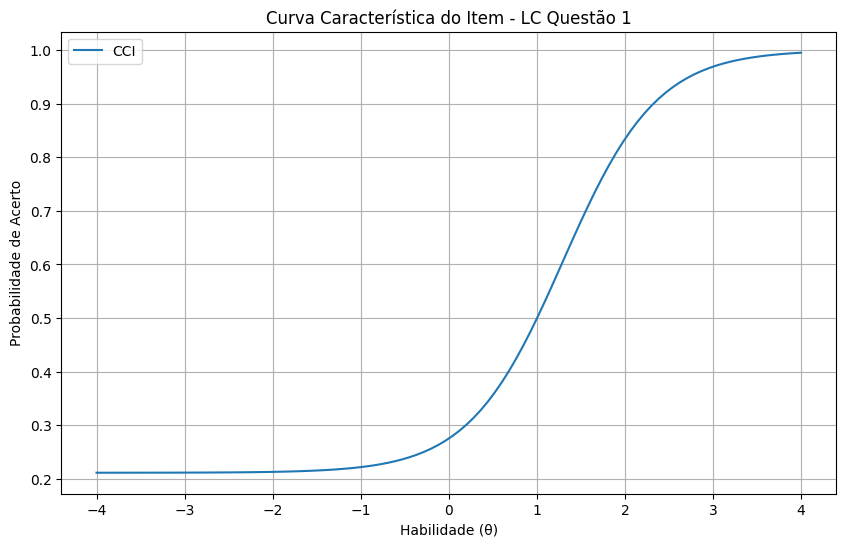

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calcular_probabilidade(a, b, c, teta):
    return c + (1 - c) / (1 + np.exp(-a * (teta - b)))

def obter_parametros_questao(dict_dados, materia, num_questao):
    for candidate_id, respostas in dict_dados[materia].items():
        A = respostas['A'][num_questao]
        B = respostas['B'][num_questao]
        C = respostas['C'][num_questao]
        return A, B, C
    raise ValueError("Questão não encontrada nos dados.")

def plotar_cci(materia, num_questao, dict_dados):
    # Obter os parâmetros do item
    a, b, c = obter_parametros_questao(dict_dados, materia, num_questao)

    # Definir um intervalo de valores para theta
    teta = np.linspace(-4, 4, 100)

    # Calcular a probabilidade de acerto para cada valor de theta
    probabilidade_acerto = calcular_probabilidade(a, b, c, teta)

    # Plotar a CCI
    plt.figure(figsize=(10, 6))
    plt.plot(teta, probabilidade_acerto, label='CCI')
    plt.xlabel('Habilidade (θ)')
    plt.ylabel('Probabilidade de Acerto')
    plt.title(f'Curva Característica do Item - {materia} Questão {num_questao}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplo de uso:
# Assumindo que `dict_dados` é o dicionário com os dados dos candidatos e os parâmetros das questões
materia = 'LC'
num_questao = 1

plotar_cci(materia, num_questao, dict)

In [ ]:
from pickle import DICT
import numpy as np
from scipy.stats import chi2

def calcular_probabilidade(a, b, c, teta):
    return c + (1 - c) / (1 + np.exp(-a * (teta - b)))
import math

def calcular_qui_quadrado(dict_dados, alpha=0.05):

    # Determinar os graus de liberdade (df)
    df = 1  # Para uma única questão, df geralmente é 1

    # Calcular o valor crítico
    valor_critico = chi2.ppf(1 - alpha, df)

    qui_quadrado_total = 0
    num_questoes_total = 0

    for materia, candidatos in dict_dados.items():
        print(materia)
        if(materia == 'Global'):
            break;
        num_questoes = len(next(iter(candidatos.values()))['A'])
        # Inicializar a chave 'result' se não existir
        if 'result' not in dict_dados[materia]:
            dict_dados[materia]['result'] = {}
        for q in range(num_questoes):
            # Inicializar somatórios para observados e esperados
            observados_acertos = 0
            observados_erros = 0
            esperados_acertos = 0
            esperados_erros = 0
            for candidate_id, respostas in candidatos.items():
                if(candidate_id==300):
                    break;
                if math.isnan(respostas['teta']):
                    continue
                A = respostas['A'][q]
                B = respostas['B'][q]
                C = respostas['C'][q]
                X = respostas['X'][q]
                teta = respostas['teta']

                # Calcular a probabilidade esperada de acerto para o candidato
                probabilidade_esperada = calcular_probabilidade(A, B, C, teta)
                # Atualizar contadores de observados
                if X == 1:
                    observados_acertos += 1
                else:
                    observados_erros += 1

                # Atualizar contadores de esperados
                esperados_acertos += probabilidade_esperada
                esperados_erros += (1 - probabilidade_esperada)
            # Calcular o valor do qui-quadrado para a questão
            if esperados_acertos > 0 and esperados_erros > 0:  # Evitar divisão por zero
                qui_quadrado = ((observados_acertos - esperados_acertos) ** 2 / esperados_acertos) + \
                               ((observados_erros - esperados_erros) ** 2 / esperados_erros)

                # Adicionar ao total
                qui_quadrado_total += qui_quadrado
                num_questoes_total += 1

                # Calcular o p-valor
                p_valor = 1 - chi2.cdf(qui_quadrado, df=df)

                # Verificar se a hipótese nula deve ser rejeitada
                rejeitar_hipotese = p_valor < alpha

                # Armazenar os resultados no dicionário
                dict_dados[materia]['result'][q] = {
                    'qui_quadrado': qui_quadrado,
                    'p_valor': p_valor,
                    'valor_critico': valor_critico,
                    'rejeitar_hipotese': rejeitar_hipotese
                }

    # Análise global
    if num_questoes_total > 0:
        # Valor crítico global (com todas as questões como graus de liberdade)
        valor_critico_global = chi2.ppf(1 - alpha, df=num_questoes_total)
        p_valor_global = 1 - chi2.cdf(qui_quadrado_total, df=num_questoes_total)
        rejeitar_hipotese_global = p_valor_global < alpha

        dict_dados['Global'] = {
            'qui_quadrado_total': qui_quadrado_total,
            'p_valor_global': p_valor_global,
            'valor_critico_global': valor_critico_global,
            'rejeitar_hipotese_global': rejeitar_hipotese_global
        }

    return dict


# Calcular os resultados
dict_resultados = calcular_qui_quadrado(dict)

# Exibir resultados para a disciplina 'Matemática' e análise global
for questao, resultados in dict_resultados['MT']['result'].items():
    print(f"Questão {questao}:")
    print(f"  Qui-Quadrado: {resultados['qui_quadrado']}")
    print(f"  P-Valor: {resultados['p_valor']}")
    print(f"  Valor Crítico: {resultados['valor_critico']}")
    print(f"  Rejeitar Hipótese Nula: {resultados['rejeitar_hipotese']}")

# Resultados da análise global
if 'Global' in dict_resultados:
    resultados_global = dict_resultados['Global']
    print("\nAnálise Global:")
    print(f"  Qui-Quadrado Total: {resultados_global['qui_quadrado_total']}")
    print(f"  P-Valor Global: {resultados_global['p_valor_global']}")
    print(f"  Valor Crítico Global: {resultados_global['valor_critico_global']}")
    print(f"  Rejeitar Hipótese Nula Global: {resultados_global['rejeitar_hipotese_global']}")


MT
CN
CH
LC
Global
Questão 0:
  Qui-Quadrado: 0.7024044582428912
  P-Valor: 0.40197693901182463
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 1:
  Qui-Quadrado: 0.07309431539946765
  P-Valor: 0.7868836146841689
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 2:
  Qui-Quadrado: 0.6756291601065721
  P-Valor: 0.4110958826089882
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 3:
  Qui-Quadrado: 1.8507323769197557
  P-Valor: 0.17369823861196654
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 4:
  Qui-Quadrado: 0.0003873973318946651
  P-Valor: 0.9842967214613694
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 5:
  Qui-Quadrado: 2.4761539571251903
  P-Valor: 0.11558458433964236
  Valor Crítico: 3.841458820694124
  Rejeitar Hipótese Nula: False
Questão 6:
  Qui-Quadrado: 0.2673937001415897
  P-Valor: 0.6050854828448858
  Valor Crítico: 3.841458820694124
  Rej